In [1]:

import numpy as np
import pandas as pd
%matplotlib inline
import glob
import keras
from functools import reduce


Using TensorFlow backend.


In [2]:
path = r'/Users/mahnooshsadeghi/Desktop/PTSD/PTSD Data/Kalman Imputed Data' # use your path
all_files = glob.glob(path + "/*.csv")

In [3]:
participant=1
li=[]

In [4]:
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    l=df.index[df['ptsd_moment'] == 'STRESSMOMENT'].tolist()
    for i in l:
        df.ptsd_moment[i-30: i+30]= 'STRESSMOMENT'
    #df['participant']=participant
    df['windowno']= -1
    j=0
    k=1
    while j<len(df.index)-59:
        df['windowno'][j:j+60]=k
        j=j+60
        k=k+1
    df1=df.dropna(axis=0, subset=['hr'])
    df1 = df1.reset_index(drop=True)
    count =  df1.groupby('windowno', as_index=False)['hr'].size()
    for i in df1.windowno:
        if count[i]<40:
            df1=df1[df1.windowno != i ]
    df1.loc[df1.ptsd_moment != 'STRESSMOMENT', 'ptsd_moment'] = 0
    df1.loc[df1.ptsd_moment == 'STRESSMOMENT', 'ptsd_moment'] = 1
    hrmean=df1.groupby('windowno', as_index=False)['hr'].mean()
    hrmean=hrmean.rename(columns={"hr": "hrmean"})
    hrsd=df1.groupby('windowno').agg(np.std,ddof=0)['hr']
    hrsd=pd.DataFrame(hrsd)
    hrsd=hrsd.rename(columns={"hr": "hrsd"})
    stress=df1.groupby('windowno', as_index=False)['ptsd_moment'].max()
    hrmin=df1.groupby('windowno', as_index=False)['hr'].min()
    hrmin=hrmin.rename(columns={"hr": "hrmin"})
    hrmax=df1.groupby('windowno', as_index=False)['hr'].max()
    hrmax=hrmax.rename(columns={"hr": "hrmax"})
    linaccx=df1.groupby('windowno', as_index=False)['linear_accel_x'].mean()
    linaccy=df1.groupby('windowno', as_index=False)['linear_accel_y'].mean()
    linaccz=df1.groupby('windowno', as_index=False)['linear_accel_z'].mean()
    acc_x=df1.groupby('windowno', as_index=False)['acc_x'].mean()
    acc_y=df1.groupby('windowno', as_index=False)['acc_y'].mean()
    acc_z=df1.groupby('windowno', as_index=False)['acc_z'].mean()
    data=reduce(lambda x,y: pd.merge(x,y, on='windowno', how='outer'),
       [hrmean,hrmin,hrmax,hrsd,linaccx,linaccy,linaccz,acc_x,acc_y,acc_z,stress])
    data['participant']=participant
    participant=participant+1
    li.append(data)

frame = pd.concat(li, axis=0, ignore_index=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.

In [5]:
frame.ptsd_moment.value_counts()


0.0    12832
1.0      512
Name: ptsd_moment, dtype: int64

In [6]:
frame.participant.value_counts()


2     955
10    827
71    590
27    573
65    569
48    480
78    477
38    456
47    435
8     394
55    356
83    317
68    283
25    259
62    254
28    215
86    202
21    198
45    197
74    184
81    174
85    168
58    161
87    160
16    156
37    156
12    155
9     150
79    150
11    148
     ... 
72     52
50     52
33     47
64     46
4      45
36     44
49     44
69     43
76     43
75     43
46     40
59     39
30     38
41     38
44     36
26     36
17     32
13     30
20     29
63     27
77     26
73     24
51     21
80     16
32     15
19     14
67     14
14     12
53     10
52      8
Name: participant, Length: 87, dtype: int64

In [7]:
frame['hrrange']= frame['hrmax']-frame['hrmin']

In [8]:
frame ['linacc']= (frame['linear_accel_x']**2+frame['linear_accel_y']**2+frame['linear_accel_z']**2)**0.5

In [9]:
export_csv = frame.to_csv (r'/Users/mahnooshsadeghi/Desktop/PTSD/PTSD Data/export_dataframe.csv', index = None, header=True) #Don't forget to add '.csv' at the end of the path



In [10]:
# Divide by class
frame0 = frame[frame['ptsd_moment'] ==0]
frame1 = frame[frame['ptsd_moment'] == 1]


In [11]:
count_class_0, count_class_1 = frame.ptsd_moment.value_counts()

In [12]:
count_class_1

512

In [13]:
frame0under = frame0.sample(3*count_class_1)
frameunder = pd.concat([frame0under, frame1], axis=0)

In [14]:
X= frameunder[['acc_x','acc_y','acc_z','linear_accel_x','linear_accel_y',
      'linear_accel_z','linacc','hrmax', 'hrmean','hrmin','hrrange','hrsd']]
#X= frameunder[['linacc','hrmax', 'hrmean','hrmin','hrrange','hrsd']]
y= frameunder[['ptsd_moment']]

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [16]:
import xgboost

/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [17]:
from xgboost import XGBClassifier

In [18]:
clf= XGBClassifier ()

In [19]:
clf.fit(X_train,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [20]:
from sklearn import metrics


predictions=clf.predict(X_test)

print(metrics.confusion_matrix(y_test,predictions))

[[423  45]
 [ 96  51]]


In [21]:
Confusion = pd.DataFrame(metrics.confusion_matrix(y_test,predictions), 
                         index=['NO PTSD','PTSD'], 
                         columns=['NO PTSD','PTSD'])
Confusion

accuracy = accuracy_score(y_test, predictions)
accuracy

0.7707317073170732

In [22]:
from sklearn.metrics import auc

fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=2)


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [23]:
y_preds = clf.predict_proba(X_test)

# take the second column because the classifier outputs scores for
# the 0 class as well
preds = y_preds[:,1]
import matplotlib.pyplot as plt


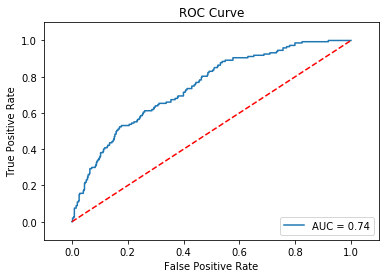

In [24]:
# fpr means false-positive-rate
# tpr means true-positive-rate
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)

# clear current figure
plt.clf()

plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))

# it's helpful to add a diagonal to indicate where chance 
# scores lie (i.e. just flipping a coin)
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

In [25]:
frame

,acc_x,acc_y,acc_z,hrmax,hrmean,hrmin,hrsd,linear_accel_x,linear_accel_y,linear_accel_z,participant,ptsd_moment,windowno,hrrange,linacc
0,1.073281,1.827534,8.908785,86.0,72.466667,67.0,4.667143,0.296569,0.330032,0.173684,1,0.0,365,19.0,0.476488
1,0.475648,0.826718,9.862674,73.0,69.491667,68.0,1.406804,0.150159,0.056768,0.128010,1,0.0,366,5.0,0.205322
2,0.470141,0.190499,9.847990,69.0,67.283333,66.0,0.866587,0.162381,0.064864,0.070411,1,0.0,367,3.0,0.188501
3,0.520579,0.345723,9.815788,71.0,68.533333,67.0,0.939267,0.158941,0.058659,0.046467,1,0.0,368,4.0,0.175676
4,2.084512,4.394996,6.980574,81.0,72.916667,68.0,3.448148,0.336181,0.566569,0.464983,1,0.0,369,13.0,0.806367
5,2.182275,1.062108,9.600150,74.0,69.658333,67.0,1.575103,0.143231,0.093801,0.088796,1,0.0,370,7.0,0.192869
6,2.204741,1.467646,9.588778,69.0,67.125000,65.0,0.997508,0.128209,0.086185,0.098142,1,0.0,371,4.0,0.183022
7,2.109651,2.173975,9.521222,74.0,68.754167,66.0,2.349420,0.121309,0.089109,0.115471,1,0.0,372,8.0,0.189710
8,1.031302,1.290634,9.500591,73.0,67.816667,65.0,2.315647,0.160458,0.085112,0.093121,1,0.0,373,8.0,0.204114
9,1.491759,4.069915,7.749347,78.5,73.217391,67.0,3.024831,0.354754,0.396288,0.426246,1,0.0,374,11.5,0.681601
